## Haro Strait Bathymetry and Cable Plan for San Juans

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import pandas as pd

import h5py
import cmocean
import pickle
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

import geopandas as gpd
import contextily as ctx
from shapely.geometry import box
from scipy.ndimage import zoom

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LightSource
import matplotlib.colors as mcolors
import pyproj

In [60]:
def gmrt_load(filepath):
    ds = xr.open_dataset(filepath, engine='scipy')
    bathy = ds['z'].values
#    if np.isnan(bathy).any():
#        print("NaNs detected in the dataset.")

    dim = np.flip(ds.dimension).values
    bathy = bathy.reshape(dim)
    bathy = np.flipud(bathy)

    bathy = bathy[~np.isnan(bathy).all(axis=1)]
    bathy = bathy[:, ~np.isnan(bathy).all(axis=0)]

    x0, xf = ds['x_range'].values
    y0, yf = ds['y_range'].values
    print(f'latitude longitude span: x0 = {x0}, xf = {xf}, y0 = {y0}, yf = {yf}')

    dim = bathy.shape
    xlon = np.linspace(x0, xf, dim[1])
    ylat = np.linspace(y0, yf, dim[0])

    bathy_flat = bathy.copy()
    bathy_flat[bathy_flat > 5] = 0

    return bathy, bathy_flat, xlon, ylat
    

def plot_2d_gmrt(cablelats, cablelongs, bathy, xlon, ylat):
    print(bathy.min(), bathy.max())
    vmin, vmax = -300, 100
    
    # Calculate the percentage of the colormap that should be water vs land, make colormap
    total_range = vmax - vmin
    water_range = 0 - vmin  # from vmin to 0
    water_fraction = water_range / total_range
    n_water = int(100 * water_fraction)
    n_land = int(100 * (1 - water_fraction))
    water_colors = plt.cm.Blues(np.linspace(1, 0.2, n_water))
    land_colors = np.linspace([1, 1, 1, 1], [0.7, 0.7, 0.7, 1], n_land)
    all_colors = np.vstack((water_colors, land_colors))
    custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', all_colors, N=256)
    
    # Create BoundaryNorm to force the transition at 0
    bounds = np.linspace(vmin, vmax, 256)
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
    
    # Set the extent of the plot and lightsource
    extent = [xlon[0], xlon[-1], ylat[0], ylat[-1]]
    ls = LightSource(azdeg=350, altdeg=45)
    
    plt.figure(figsize=(14, 8))
    ax = plt.gca()
    
    # Plot the bathymetry relief in background, cable location, and isoline at 0
    rgb = ls.shade(bathy, cmap=custom_cmap, vert_exag=0.1, blend_mode='overlay', norm=norm)
    plot = ax.imshow(rgb, extent=extent, aspect='equal', origin='lower')
    ax.plot(cablelongs, cablelats, 'tab:red', label='ODL cable')
    ax.contour(bathy, levels=[0], colors='k', extent=extent)
    
    # Use a proxy artist for the color bar
    im = ax.imshow(bathy, cmap=custom_cmap, extent=extent, aspect='equal', origin='lower', norm=norm)
    cbar = plt.colorbar(im, ax=ax, label='Depth [m]', aspect=55, pad=0.1, orientation='vertical')
    cbar.set_label('Depth [m]', fontsize=14, rotation=90, labelpad=-70)
    cbar.set_ticks([-300, -200, -100, 0, 100])
    cbar.ax.tick_params(labelsize=12)
    im.remove()
    
    plt.subplots_adjust(bottom=0.0, top=1, left=0.0, right=1)
    plt.title("Haro Strait Cable Deployment", fontsize=20)
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    plt.legend(loc='upper right', fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return

latitude longitude span: x0 = -123.2413330078125, xf = -123.1226806640625, y0 = 48.50896252736957, yf = 48.596592251456684
-312.3044738769531 328.2367248535156


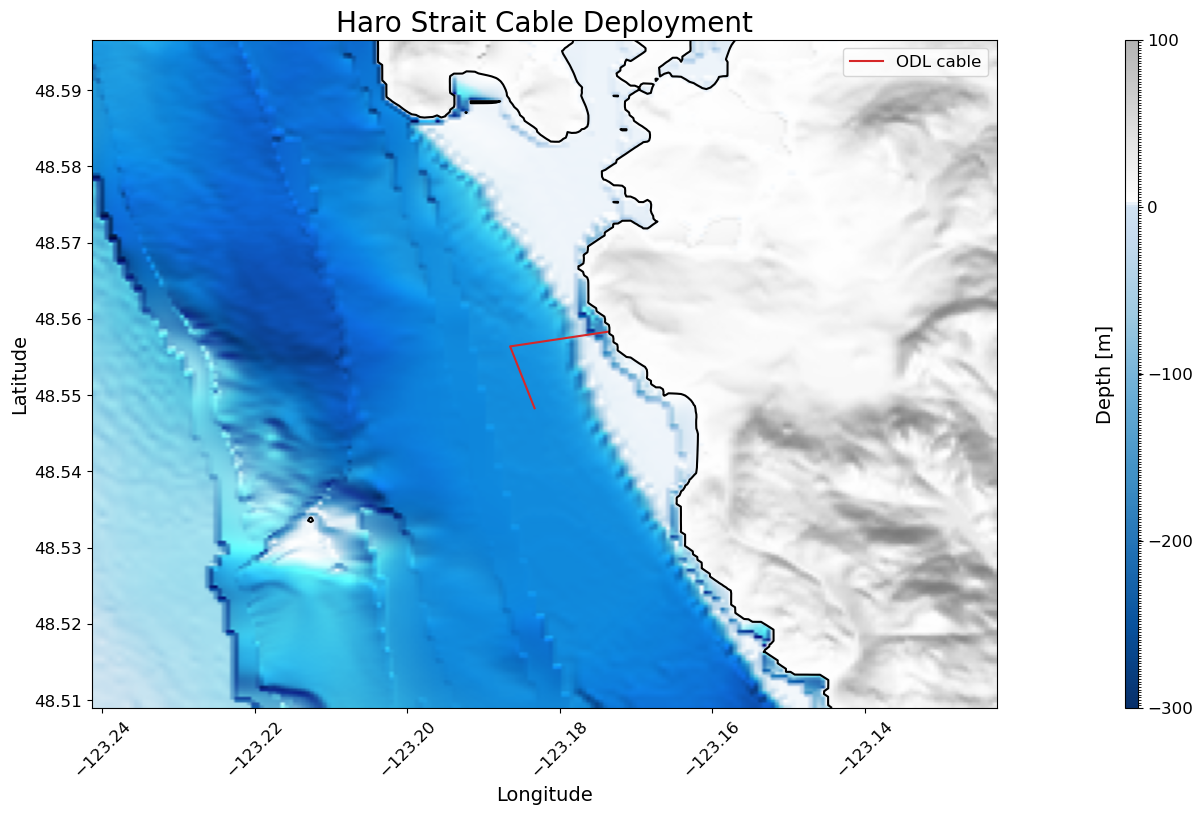

In [61]:
bath, bath_flat, xln, ylt = gmrt_load('/home/isabrand/Documents/ODL/SanJuans/bathymetry/haro_strait.grd')

cablelats = [48.5583244, 48.55638, 48.54827]
cablelongs = [-123.1735281, -123.1865, -123.18329]

lat = [48.555586]
long = [-123.18505]
mode9_cablelats = []
mode9_cablelongs = []

plot_2d_gmrt(cablelats, cablelongs, bath, xln, ylt)
#my_2d_gmrt_plot(cablelats, cablelongs, bath_flat, xln, ylt, mode9_cablelats, mode9_cablelongs)